# Image Segmentation

## Thresholding

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

imagesDir = './data'

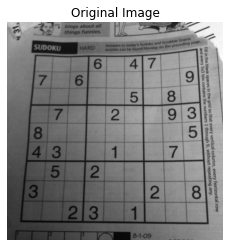

In [8]:
img = cv2.imread(os.path.join(imagesDir, 'sudoku.png'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

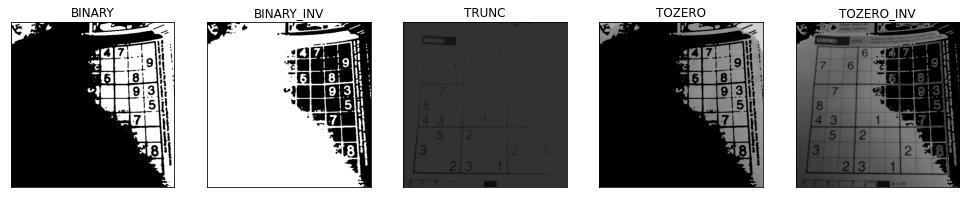

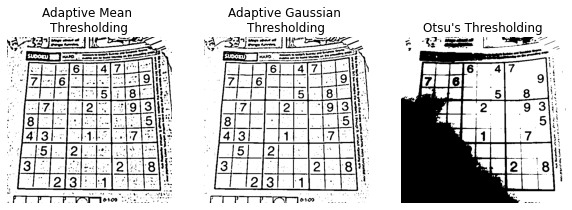

In [39]:
blur1 = cv2.medianBlur(img, 5)

# Global Thresholding
_, thresh_binary = cv2.threshold(blur1, 127, 255, cv2.THRESH_BINARY)
_, thresh_binary_inv = cv2.threshold(blur1, 127, 255, cv2.THRESH_BINARY_INV)
_, thresh_truncate = cv2.threshold(blur1, 50, 255, cv2.THRESH_TRUNC)
_, thresh_to_zero = cv2.threshold(blur1, 127, 255, cv2.THRESH_TOZERO)
_, thresh_to_zero_inv = cv2.threshold(blur1, 127, 255, cv2.THRESH_TOZERO_INV)

titles = ['BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [thresh_binary, thresh_binary_inv, thresh_truncate, thresh_to_zero, thresh_to_zero_inv]

fig = plt.figure(figsize=(17, 15))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

plt.show()

# Adaptive Thresholding
adaptive_mean_thresh = cv2.adaptiveThreshold(blur1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
adaptive_gaussian_thresh = cv2.adaptiveThreshold(blur1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Otsu's Thresholding (after gaussian filtering)
blur2 = cv2.GaussianBlur(img,(5,5),0)
_, otsu_thresh = cv2.threshold(blur2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

titles = ['Adaptive Mean \nThresholding', 'Adaptive Gaussian \nThresholding', 'Otsu\'s Thresholding']
images = [adaptive_mean_thresh, adaptive_gaussian_thresh, otsu_thresh]

fig = plt.figure(figsize=(10, 8))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.axis('off')

plt.show()

## Segmentation with K-Means

[K-Means](https://docs.opencv.org/master/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88)

In [ ]:
img2 = cv2.imread(os.path.join(imagesDir, 'home.jpg'))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [ ]:
Z = img2.reshape((-1,3))
Z = np.float32(Z)

# Define criteria, number of clusters(K) and apply kmeans
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 4
ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [ ]:
# Convert back to uint8, and make resulting image
center = np.uint8(center)
result = center[label.flatten()]
result = result.reshape((img2.shape))

plt.imshow(result)
plt.title('K-Means Segmentation')
plt.axis('off')
plt.show()

## Segmentation with Watersheds

[Watershed](https://docs.opencv.org/4.5.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1)

Please check [this page](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html) to fully follow and comprehend all the morphological operations applied.

In [ ]:
coins = cv2.imread(os.path.join(imagesDir, 'watershed_coins.jpg')) # Change this, according to your image's path
coins = cv2.cvtColor(coins, cv2.COLOR_BGR2RGB)
coinsGray = cv2.cvtColor(coins, cv2.COLOR_RGB2GRAY)

plt.imshow(coinsGray, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

In [ ]:
# First Step: finding an approximate estimate of the coins, using Otsu’s binarization
ret, thresh = cv2.threshold(coinsGray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(thresh, cmap='gray')
plt.title('Image after Otsu')
plt.axis('off')
plt.show()

In [ ]:
# Removing Noise
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# Getting the background area
bg = cv2.dilate(opening,kernel,iterations=3)

# Getting the foreground area
distTransform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
ret, fg = cv2.threshold(distTransform, 0.7 * distTransform.max(), 255, 0)

# Getting the "unknown" area
fg = np.uint8(fg)
unknown = cv2.subtract(bg, fg)

plt.imshow(distTransform, cmap='gray')
plt.title('Distance Transform')
plt.axis('off')
plt.show()

plt.imshow(fg, cmap='gray')
plt.title('Foreground')
plt.axis('off')
plt.show()

In [ ]:
# Marker labelling
ret, markers = cv2.connectedComponents(fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [ ]:
# Finally apply Watershed
markers = cv2.watershed(coins,markers)
coins[markers == -1] = [255,0,0]

In [ ]:
plt.imshow(markers, cmap='Spectral')
plt.title('Marker Image After Segmentation')
plt.axis('off')
plt.show()

In [ ]:
plt.imshow(coins)
plt.title('Watershed Segmentation Result')
plt.axis('off')
plt.show()

## Segmentation with Meanshift

`pyrMeanShiftFiltering(src, sp, sr, maxLevel, termcrit)`

*sp*: The spacial window radius

*sr*: The color window radius

*maxLevel*: Maximum level of the pyramid for the segmentation (by default is 1)

*termcrit*: Termination criteria (when to stop meanshift iterations)
```

In [ ]:
img3 = cv2.imread(os.path.join(imagesDir, 'streetLines_01.jpg')) # Change this, according to your image's path
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

plt.imshow(img3)
plt.title('Original Image')
plt.axis('off')
plt.show()

### 1. Varying the spatial window radius

In [ ]:
for spatialRadius in range(10,50,10):
    segmentedImg = cv2.pyrMeanShiftFiltering(img3, spatialRadius, 10)
    plt.imshow(segmentedImg)
    plt.title('spatialRadius = {0}'.format(spatialRadius))
    plt.axis('off')
    plt.show()  

### 2. Varying the color window radius

In [ ]:
for colorRadius in range(10,50,10):
    segmentedRoadImg = cv2.pyrMeanShiftFiltering(img3, 20, colorRadius)
    plt.imshow(segmentedRoadImg)
    plt.title('colorRadius = {0}'.format(colorRadius))
    plt.axis('off')
    plt.show()

### 3. Varying the maximum level of the pyramid

In [ ]:
for maxPyrLevel in range(2,12,2):
    segmentedRoadImg = cv2.pyrMeanShiftFiltering(img3, 40, 20, maxPyrLevel)
    plt.imshow(segmentedRoadImg)
    plt.title('maxPyrLevel = {0}'.format(maxPyrLevel))
    plt.axis('off')
    plt.show()

## Segmentation with GrabCut

[GrabCut](https://docs.opencv.org/4.x/d3/d47/group__imgproc__segmentation.html#ga909c1dda50efcbeaa3ce126be862b37f)

In [ ]:
# Opening an image
img4 = cv2.imread(os.path.join(imagesDir, 'giraffe.jpg')) # Change this, according to your image's path
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

plt.imshow(img4)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Defining the image mask for the GrabCut output; it has the same spatial dimensions as the input image
mask = np.zeros(img4.shape[:2], np.uint8)

In [ ]:
# Define the bounding box coordinates that approximately delimits the object of interest: (x, y, width, heigh)
rect = (0, 0, 600, 800)

# Note that you can use the selectROI function to manually draw the bounding box and obtain the corresponding coordinates
# bb = cv2.selectROI(img3)
# print(bb)

# Allocating memory for the two arrays that this algorithm internally uses for the segmentation of the foreground and background
bgModel = np.zeros((1,65), np.float64)
fgModel = np.zeros((1,65), np.float64)

# Number of iterations the algorithm will run
nIter = 5

# Applying GrabCut, using the defined bounding box
(mask, bgModel, fgModel) = cv2.grabCut(img4, mask, rect, bgModel, fgModel, nIter, cv2.GC_INIT_WITH_RECT)

# All definite background and probable background pixels are set to 0, and all definite foreground and probable foreground pixels are set to 1
outputMask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1)

# Scale the mask from the range [0, 1] to [0, 255]
outputMask = (outputMask * 255).astype("uint8")

# Apply a bitwise AND to the image using the generated mask by
# GrabCut, obtaining the final output
grabcut_output = cv2.bitwise_and(img4, img4, mask=outputMask)
plt.imshow(grabcut_output)
plt.axis('off')
plt.show()